In [14]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [15]:
start_day_to_analyze = '2020-05-07'
end_day_to_analyze = '2020-05-08'

In [16]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [17]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [18]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [19]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [20]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2882,541,AAL,buy,1261,9.74,"{'avg': 9.5627, 'rsi': 65.14371636444677, 'mac...",2020-05-07 16:28:50.354206+00:00,2020-05-07 16:28:50.475694,9.67,9.97
1,2891,541,AAL,sell,1261,9.76,"{'avg': 9.5725, 'rsi': [62.44721138001832, 58....",2020-05-07 16:38:07.614256+00:00,2020-05-07 16:38:07.739285,9.67,9.97
2,2855,539,ALLY,buy,557,15.09,"{'avg': 14.8197, 'rsi': 69.60586395878799, 'ma...",2020-05-07 14:35:49.618892+00:00,2020-05-07 14:35:49.746533,14.92,15.60
3,2857,539,ALLY,sell,557,15.20,"{'avg': 14.8391, 'rsi': [76.69472383045529, 79...",2020-05-07 14:41:41.357979+00:00,2020-05-07 14:41:41.586166,14.92,15.60
4,2886,541,APA,buy,574,12.29,"{'avg': 12.0609, 'rsi': 66.47170574952428, 'ma...",2020-05-07 16:32:14.380854+00:00,2020-05-07 16:32:14.542767,12.13,12.79
5,2895,541,APA,sell,574,12.17,"{'avg': 12.0658, 'rsi': [40.043000341846614, 3...",2020-05-07 16:42:07.395561+00:00,2020-05-07 16:42:07.788713,12.13,12.79
6,2876,541,CCL,buy,788,13.59,"{'avg': 13.3541, 'rsi': 63.78492821707481, 'ma...",2020-05-07 16:19:55.691965+00:00,2020-05-07 16:19:55.927235,13.47,13.95
7,2889,541,CCL,sell,788,13.61,"{'avg': 13.3679, 'rsi': [57.94099820503617, 57...",2020-05-07 16:36:08.549387+00:00,2020-05-07 16:36:08.694903,13.47,13.95
8,2878,541,FEYE,buy,1455,11.17,"{'avg': 10.9145, 'rsi': 66.0342915126374, 'mac...",2020-05-07 16:26:15.987994+00:00,2020-05-07 16:26:16.133508,11.11,11.36
9,2892,541,FEYE,sell,1455,11.18,"{'avg': 10.9236, 'rsi': [55.06031646549185, 56...",2020-05-07 16:38:20.361690+00:00,2020-05-07 16:38:20.544585,11.11,11.36


In [21]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [22]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [23]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
1,539,momentum_long,PAPER,v0.1-372-gf0788c7,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-05-07 13:45:01.829263,None,None


,symbol,count,revenue
1,NCLH,5,-63.87
7,GT,2,-48.96
2,UNM,3,-48.15
4,GPS,2,-40.62
3,FRO,3,0.00
6,MOS,2,0.00
5,MT,2,5.91
8,ALLY,2,61.27
0,PENN,6,80.85


TOTAL REVENUE: -53.57 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
3,541,momentum_long,PAPER,v0.1-373-g0809154,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 240}",2020-05-07 16:10:03.604287,None,None


,symbol,count,revenue
9,APA,2,-68.88
7,PENN,2,-66.78
5,OLN,2,-63.00
6,WMB,2,-40.88
1,SU,3,0.00
4,FEYE,2,14.55
2,NCLH,3,14.80
8,CCL,2,15.76
3,AAL,2,25.22
0,GNMK,4,49.20


TOTAL REVENUE: -120.01 $


In [24]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [25]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].between_time("9:30", "16:00").dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

PENN analysis for run 539 with profit 80.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1147.30,-1147.30,buy,2020-05-07 13:48:25.483336,16.39,[15.16],"[17.915, 18.05]",70,"{'avg': 15.8158, 'rsi': 67.80418098301129, 'macd': [0.16238753572390152, 0.17146073208306767, 0.1742222308592467, 0.17834110048890928, 0.18835854990828693], 'vwap': 16.3596, 'supports': [15.16, 15.65], 'sell_macd': [0.10455155252127035, 0.10980219404412495, 0.11090915894447839, 0.11289758407534478, 0.11872625841010631], 'slow macd': [0.054338671344694944, 0.06043128015190824, 0.06546021567561588, 0.07077238671813646, 0.07731545589925126], 'macd_signal': [0.08170562666539696, 0.0996566477489311, 0.11456976437099423, 0.12732403159457722, 0.13953093525731916], 'resistances': [17.7871, 17.915, 17.925, 18.05], 'sell_macd_signal': [0.05285384666346055, 0.06424351613959343, 0.07357664470057043, 0.0814408325755253, 0.0888979177424415]}",20.42,15.06
1,-560.35,586.95,sell,2020-05-07 13:59:15.666241,16.77,None,None,35,"{'avg': 16.0085, 'rsi': [72.96918484693022, 74.17022283420941], 'vwap': 16.7011, 'reasons': 'scale-out', 'movement': 0.020134228187919358, 'sell_macd': [0.13153026831272996, 0.13307991155894072, 0.13203963471755742, 0.13107267049417715, 0.1306948714825289], 'sell_macd_signal': [0.12351539375727827, 0.12542829731761077, 0.1267505647976001, 0.1276149859369155, 0.12823096304603818]}",20.42,15.06
2,30.45,590.80,sell,2020-05-07 14:00:24.730340,16.88,None,None,35,"{'avg': 16.0443, 'rsi': [78.47419551688756, 79.09119106449101], 'vwap': 16.9296, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.009516994633273768, 'sell_macd': [0.13307991155894072, 0.13203963471755742, 0.13107267049417715, 0.14004552083317634, 0.146756241605992], 'sell_macd_signal': [0.12542829731761077, 0.1267505647976001, 0.1276149859369155, 0.13010109291616767, 0.13343212265413254]}",20.42,15.06
3,-2403.15,-2433.60,buy,2020-05-07 14:48:14.282074,16.90,"[15.16, 16.2601, 16.28]",[16.9],144,"{'avg': 16.2775, 'rsi': 70.04392692489336, 'macd': [0.03803531925496628, 0.06119742550828278, 0.07745038709697027, 0.0950052671211914, 0.10755675127553843], 'vwap': 16.9028, 'supports': [16.2601, 16.28], 'sell_macd': [0.024679176472339748, 0.03964806618468231, 0.05001800536073375, 0.06116317867504861, 0.06897548023588129], 'slow macd': [0.06276413801974456, 0.06695098478415318, 0.07045603495039288, 0.07471165122096934, 0.07848347306572023], 'macd_signal': [0.005798195899846552, 0.016878041821533796, 0.028992510876621094, 0.04219506212553516, 0.05526739995553581], 'resistances': [17.7871, 17.915, 17.925, 18.05], 'sell_macd_signal': [0.0031353491271562525, 0.010437892538661463, 0.01835391510307592, 0.02691576781747046, 0.03532771030115263]}",18.87,16.25
4,-1161.15,1242.00,sell,2020-05-07 14:59:11.852647,17.25,None,None,72,"{'avg': 16.3682, 'rsi': [78.32196800076431, 78.91225150005117], 'vwap': 17.2399, 'reasons': 'scale-out', 'movement': 0.020118343195266265, 'sell_macd': [0.08412195879036943, 0.08925849267122743, 0.09781087630993213, 0.10372947555684675, 0.10803319606668893], 'sell_macd_signal': [0.06793585119243843, 0.07220037948819623, 0.07732247885254341, 0.08260387819340408, 0.08768974176806105]}",18.87,16.25
5,80.85,1242.00,sell,2020-05-07 14:59:12.800129,17.25,None,None,72,"{'avg': 16.3699, 'rsi': [78.32196800076431, 79.73976763641211], 'vwap': 17.2496, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0011594202898550477, 'sell_macd': [0.08412195879036943, 0.08925849267122743, 0.09781087630993213, 0.10372947555684675, 0.10959163762513313], 'sell_macd_signal': [0.06793585119243843, 0.07220037948819623, 0.07732247885254341, 0.08260387819340408, 0.08800143007974989]}",18.87,16.25


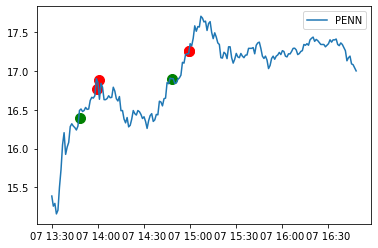

NCLH analysis for run 539 with profit -63.87


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3558.00,-3558.00,buy,2020-05-07 13:54:43.722533,11.86,"[11.45, 11.5739]","[12.52, 12.6114]",300,"{'avg': 11.5609, 'rsi': 74.29235410895815, 'macd': [0.10716594537365332, 0.10824269534017361, 0.10785276787416898, 0.10990792136520078, 0.1150518972186827], 'vwap': 11.8623, 'supports': [11.45, 11.5739], 'sell_macd': [0.06395064366105352, 0.0644281749150597, 0.06396354764655676, 0.06510846733802644, 0.06827193115815788], 'slow macd': [0.05992454203065911, 0.06264858827510622, 0.06505460029244681, 0.06788387468298573, 0.07133794300521501], 'macd_signal': [0.10608050447059887, 0.10651294264451382, 0.10678090769044485, 0.10740631042539603, 0.10893542778405337], 'resistances': [12.52, 12.6114], 'sell_macd_signal': [0.06451049604971584, 0.06449403182278461, 0.06438793498753904, 0.06453204145763652, 0.0652800193977408]}",12.81,11.55
1,-87.00,3471.00,sell,2020-05-07 14:08:05.861189,11.57,None,None,300,"{'avg': 11.609, 'rsi': [43.66196152298165, 43.327060778089816], 'vwap': 11.5807, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.023608768971332156, 'sell_macd': [0.028435160790513336, 0.019796305622818977, 0.01150893399055164, 0.004122554355143748, -0.0019463460666706567], 'sell_macd_signal': [0.04487665018355231, 0.03986058127140564, 0.03419025181523484, 0.028176712323216623, 0.02215210064523917]}",12.81,11.55
2,-3242.37,-3155.37,buy,2020-05-07 14:41:46.005925,11.73,"[11.45, 11.57, 11.5739, 11.5748, 11.585]","[11.74, 11.8989]",269,"{'avg': 11.622, 'rsi': 59.72660342250978, 'macd': [0.0094646385689785, 0.01208177541640687, 0.013595694309218587, 0.016621178406900583, 0.019424379014406412], 'vwap': 11.741, 'supports': [11.45, 11.57, 11.5739, 11.5748, 11.585], 'sell_macd': [0.005691741177516363, 0.007395458393252952, 0.008367245075731944, 0.010314517229927489, 0.01210311219124982], 'slow macd': [0.03237206906826806, 0.03234243319574759, 0.032183472030034466, 0.032385589770767, 0.03264449843223893], 'macd_signal': [0.004985754692824772, 0.0064049588375411914, 0.00784310593187667, 0.009598720426881454, 0.011563852144386445], 'resistances': [11.8989], 'sell_macd_signal': [0.002514956173260431, 0.003491056617258935, 0.004466294308953537, 0.005635938893148328, 0.006929373552768627]}",12.11,11.62
3,-9130.83,-5888.46,buy,2020-05-07 14:41:46.313921,11.73,"[11.45, 11.57, 11.5739, 11.5748, 11.585]","[11.74, 11.8989]",502,"{'avg': 11.622, 'rsi': 59.72660342250978, 'macd': [0.0094646385689785, 0.01208177541640687, 0.013595694309218587, 0.016621178406900583, 0.019424379014406412], 'vwap': 11.741, 'supports': [11.45, 11.57, 11.5739, 11.5748, 11.585], 'sell_macd': [0.005691741177516363, 0.007395458393252952, 0.008367245075731944, 0.010314517229927489, 0.01210311219124982], 'slow macd': [0.03237206906826806, 0.03234243319574759, 0.032183472030034466, 0.032385589770767, 0.03264449843223893], 'macd_signal': [0.004985754692824772, 0.0064049588375411914, 0.00784310593187667, 0.009598720426881454, 0.011563852144386445], 'resistances': [11.8989], 'sell_macd_signal': [0.002514956173260431, 0.003491056617258935, 0.004466294308953537, 0.005635938893148328, 0.006929373552768627]}",12.11,11.62
4,-63.87,9066.96,sell,2020-05-07 14:51:05.900228,11.76,None,None,771,"{'avg': 11.6363, 'rsi': [55.98486708499683, 55.32629170913589], 'vwap': 11.7808, 'reasons': 'bail', 'movement': 0.004262574595055323, 'sell_macd': [0.02508050319097954, 0.024361041455735588, 0.022387940863911382, 0.02133892818373795, 0.019984646508488524], 'sell_macd_signal': [0.018416727529474992, 0.01960559031472711, 0.020162060424563966, 0.020397433976398763, 0.020314876482816716]}",12.11,11.62


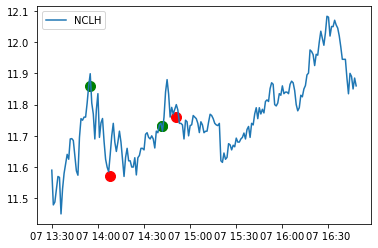

UNM analysis for run 539 with profit -48.15


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3228.76,-3228.76,buy,2020-05-07 14:44:07.695962,15.23,"[14.9, 14.97, 15.02, 15.05]","[15.235, 15.37, 15.6]",212,"{'avg': 14.9742, 'rsi': 71.58740706956273, 'macd': [0.026773145924735786, 0.03146957027655972, 0.03399275664591883, 0.04196399660315642, 0.04852876868813638], 'vwap': 15.2236, 'supports': [14.16, 14.225, 14.9, 14.97, 15.02, 15.05], 'sell_macd': [0.01639958182403589, 0.019423004347858708, 0.02100719067359158, 0.026124645074506958, 0.030292471295030765], 'slow macd': [0.05246163224342126, 0.052911275058454166, 0.05308040061509267, 0.0544305950586601, 0.05574569903083848], 'macd_signal': [0.012208405945813109, 0.01606063881196243, 0.01964706237875371, 0.02411044922363425, 0.028994113116534676], 'resistances': [15.37], 'sell_macd_signal': [0.006618502160797589, 0.009179402598209813, 0.011544960213286166, 0.014460897185530324, 0.017627212007430414]}",16.12,14.94
1,-4888.83,-1660.07,buy,2020-05-07 14:44:07.761614,15.23,"[14.9, 14.97, 15.02, 15.05]","[15.235, 15.37, 15.6]",109,"{'avg': 14.9742, 'rsi': 71.58740706956273, 'macd': [0.026773145924735786, 0.03146957027655972, 0.03399275664591883, 0.04196399660315642, 0.04852876868813638], 'vwap': 15.2236, 'supports': [14.16, 14.225, 14.9, 14.97, 15.02, 15.05], 'sell_macd': [0.01639958182403589, 0.019423004347858708, 0.02100719067359158, 0.026124645074506958, 0.030292471295030765], 'slow macd': [0.05246163224342126, 0.052911275058454166, 0.05308040061509267, 0.0544305950586601, 0.05574569903083848], 'macd_signal': [0.012208405945813109, 0.01606063881196243, 0.01964706237875371, 0.02411044922363425, 0.028994113116534676], 'resistances': [15.37], 'sell_macd_signal': [0.006618502160797589, 0.009179402598209813, 0.011544960213286166, 0.014460897185530324, 0.017627212007430414]}",16.12,14.94
2,-48.15,4840.68,sell,2020-05-07 14:59:24.524586,15.08,None,None,321,"{'avg': 15.0069, 'rsi': [46.88247771535193, 45.60832478432821], 'vwap': 15.086, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.00919238345370982, 'sell_macd': [0.01408636137060526, 0.00687660349986885, 0.00402644667202523, 0.0017532537325113395, -0.0005603154896114404], 'sell_macd_signal': [0.02278421190018795, 0.01960269022012413, 0.01648744151050435, 0.013540603954905747, 0.010720420066002309]}",16.12,14.94


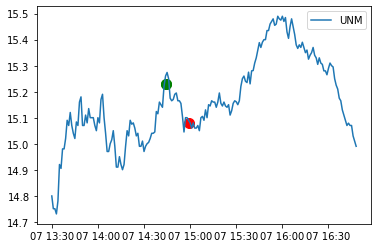

FRO analysis for run 539 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2439.70,-2439.70,buy,2020-05-07 13:48:09.998768,7.87,[7.625],[7.895],310,"{'avg': 7.7415, 'rsi': 74.76196926093641, 'macd': [0.0902465250013531, 0.08985320199250157, 0.09011651642154828, 0.09368331243950223, 0.09580107783887293], 'vwap': 7.8999, 'supports': [7.625], 'sell_macd': [0.05678890407131476, 0.05619384555723084, 0.05603933443512332, 0.05804829545120693, 0.05911439110723027], 'slow macd': [0.025962731757991797, 0.028482041177580797, 0.03107420543578243, 0.03428902876100359, 0.037270297196146274], 'macd_signal': [0.06617624589356982, 0.07091163711335617, 0.0747526129749946, 0.07853875286789612, 0.08199121786209149], 'resistances': [8.23, 8.37], 'sell_macd_signal': [0.04217475939945249, 0.04497857663100816, 0.04719072819183119, 0.04936224164370634, 0.05131267153641113]}",8.81,7.6
1,-401.37,2038.33,sell,2020-05-07 13:51:24.036227,7.87,None,None,259,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68.868066942545], 'vwap': 7.875, 'reasons': 'bail', 'movement': 0.0006353240152477628, 'sell_macd': [0.05804829545120693, 0.05834036513320395, 0.056511583520043374, 0.053833161697840026, 0.05234564908706041], 'sell_macd_signal': [0.04936224164370634, 0.051157866341605865, 0.052228609777293364, 0.0525495201614027, 0.05250874594653424]}",8.81,7.6
2,0.00,401.37,sell,2020-05-07 13:51:24.120174,7.87,None,None,51,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68.868066942545], 'vwap': 7.875, 'reasons': 'bail', 'movement': 0.0006353240152477628, 'sell_macd': [0.05804829545120693, 0.05834036513320395, 0.056511583520043374, 0.053833161697840026, 0.05234564908706041], 'sell_macd_signal': [0.04936224164370634, 0.051157866341605865, 0.052228609777293364, 0.0525495201614027, 0.05250874594653424]}",8.81,7.6


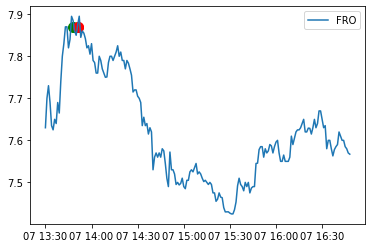

GPS analysis for run 539 with profit -40.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5226.44,-5226.44,buy,2020-05-07 14:44:13.599902,7.72,"[7.4949, 7.52, 7.54, 7.59]","[7.84, 7.845]",677,"{'avg': 7.5328, 'rsi': 71.07031385200105, 'macd': [0.022308400128900452, 0.023572284382382236, 0.024293877066650538, 0.026975536553565327, 0.0303645798945551], 'vwap': 7.72, 'supports': [7.4949, 7.52, 7.54, 7.59], 'sell_macd': [0.013120472104608538, 0.013932128076576511, 0.014383650547244997, 0.01610712714065876, 0.01827987348435034], 'slow macd': [0.03621738074573688, 0.03632203413523527, 0.03636022658333449, 0.036817019832732, 0.03749827260663441], 'macd_signal': [0.017308793773454064, 0.018561491895239698, 0.019707968929521865, 0.021161482454330558, 0.023002101942375466], 'resistances': [7.82], 'sell_macd_signal': [0.009756057912524973, 0.01059127194533528, 0.011349747665717223, 0.01230122356070553, 0.013496953545434492]}",8.14,7.58
1,-40.62,5185.82,sell,2020-05-07 15:07:18.745267,7.66,None,None,677,"{'avg': 7.5614, 'rsi': [46.78654651123863, 45.59640521245431], 'vwap': 7.6693, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.007772020725388551, 'sell_macd': [0.0034998461926400992, 0.0028296316148530565, 0.0025303782865142566, 0.0012253707801912483, -6.717235175113245e-05], 'sell_macd_signal': [0.007463630386072247, 0.006536830631828409, 0.005735540162765578, 0.004833506286250712, 0.003853370558650343]}",8.14,7.58


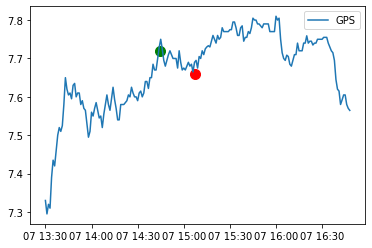

MT analysis for run 539 with profit 5.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6577.83,-6577.83,buy,2020-05-07 14:22:15.478782,11.13,"[10.73, 10.95, 11.0, 11.0]","[11.79, 11.825, 11.83]",591,"{'avg': 10.9783, 'rsi': 72.72697725798255, 'macd': [0.023238437593052552, 0.027419306982398695, 0.029983585769123522, 0.03244866361320575, 0.035605648663548095], 'vwap': 11.1228, 'supports': [10.45, 10.95, 11.0, 11.0], 'sell_macd': [0.011144673871884336, 0.014027683054683493, 0.015832265754857744, 0.017552300771162876, 0.019703596877748808], 'slow macd': [0.06694930477955552, 0.06699046510173723, 0.06684122401454573, 0.06675695026897088, 0.06689251936547436], 'macd_signal': [0.026997476078101434, 0.027081842258960886, 0.027662190960993413, 0.02861948549143588, 0.030016718125858325], 'resistances': [11.79], 'sell_macd_signal': [0.012867345927155032, 0.013099413352660724, 0.013645983833100127, 0.014427247220712678, 0.015482517152119905]}",11.61,10.97
1,5.91,6583.74,sell,2020-05-07 14:39:32.980438,11.14,None,None,591,"{'avg': 10.9936, 'rsi': [60.70266507319475, 62.70316307909515], 'vwap': 11.14, 'reasons': 'bail', 'movement': 0.0008984725965857849, 'sell_macd': [0.016167849423226244, 0.015827815812558654, 0.0158767790274581, 0.015189259727023341, 0.014975747808152917], 'sell_macd_signal': [0.014752508247103512, 0.014967569760194541, 0.015149411613647253, 0.01515738123632247, 0.015121054550688559]}",11.61,10.97


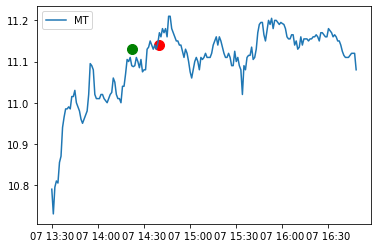

MOS analysis for run 539 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5702.1,-5702.1,buy,2020-05-07 14:41:48.829835,11.45,"[11.24, 11.27, 11.29]",[11.57],498,"{'avg': 11.3201, 'rsi': 67.812954373279, 'macd': [0.008537458653425034, 0.010824264588528365, 0.010498266223285313, 0.01650498241891185, 0.022618449724101097], 'vwap': 11.45, 'supports': [10.8, 11.24, 11.27, 11.29], 'sell_macd': [0.005724973778534093, 0.00718357110194745, 0.006928146014971048, 0.010794981713235785, 0.014706866910414007], 'slow macd': [0.02599925233992373, 0.02600305990784335, 0.02556513466760002, 0.026400829782964763, 0.027447343633955512], 'macd_signal': [-0.0007516102563905193, 0.0015635647125932578, 0.0033505050147316687, 0.005981400495567705, 0.009308810341274384], 'resistances': [11.57], 'sell_macd_signal': [-0.0005405315490101318, 0.0010042889811813847, 0.0021890603879393174, 0.003910244652998611, 0.006069569104481691]}",12.02,11.26
1,0.0,5702.1,sell,2020-05-07 14:52:31.558298,11.45,None,None,498,"{'avg': 11.3314, 'rsi': [61.13876425493922, 58.29588014187088], 'vwap': 11.4502, 'reasons': 'bail', 'movement': 0.0004366812227074919, 'sell_macd': [0.020148844339095362, 0.01879920561919768, 0.018282614335911163, 0.018941340422493624, 0.01842942126369529], 'sell_macd_signal': [0.01880475259184798, 0.01880364319731792, 0.018699437425036568, 0.01874781802452798, 0.01868413867236144]}",12.02,11.26


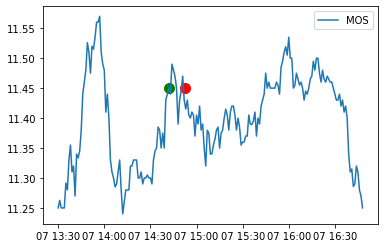

GT analysis for run 539 with profit -48.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4051.44,-4051.44,buy,2020-05-07 14:46:15.604437,6.62,"[6.3, 6.34, 6.4801]","[6.745, 6.745]",612,"{'avg': 6.4222, 'rsi': 69.35633038101003, 'macd': [0.03366578070146353, 0.033903081485929576, 0.032904920203264076, 0.03414106255783356, 0.03511933861844607], 'vwap': 6.6209, 'supports': [6.135, 6.155, 6.16, 6.3, 6.34, 6.4801], 'sell_macd': [0.01916377254477819, 0.01932113403628488, 0.01867334904218243, 0.019484512046230584, 0.020123281763070544], 'slow macd': [0.04208988417003301, 0.042325043780161664, 0.04231376912513696, 0.04271552919802346, 0.043096811809346214], 'macd_signal': [0.03433589503296427, 0.03424933232355733, 0.03398044989949868, 0.03401257243116566, 0.03423392566862174], 'resistances': [6.745, 6.745], 'sell_macd_signal': [0.019621023216870558, 0.01956104538075342, 0.019383506113039222, 0.019403707299677494, 0.019547622192356104]}",7.09,6.47
1,-48.96,4002.48,sell,2020-05-07 14:57:07.855912,6.54,None,None,612,"{'avg': 6.4466, 'rsi': [43.26950913020842, 41.407397335478926], 'vwap': 6.532, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.013293051359516628, 'sell_macd': [0.007972865211213431, 0.005380658330865096, 0.003389579484737837, 0.0011758871437983487, -0.0009799236042553616], 'sell_macd_signal': [0.014449094531500265, 0.01263540729137323, 0.010786241730046152, 0.008864170812796592, 0.006895351929386201]}",7.09,6.47


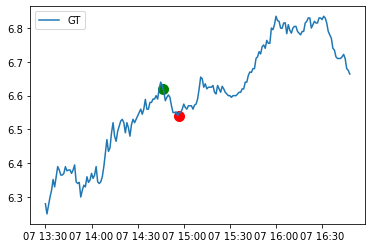

ALLY analysis for run 539 with profit 61.27


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8405.13,-8405.13,buy,2020-05-07 14:35:49.746533,15.09,"[14.84, 14.88, 14.95]",[15.2498],557,"{'avg': 14.8197, 'rsi': 69.60586395878799, 'macd': [0.019530856370359118, 0.022247443095709585, 0.024122290893682674, 0.028507174030057314, 0.03401091809382706], 'vwap': 15.0759, 'supports': [14.17, 14.84, 14.88, 14.95], 'sell_macd': [0.010196396951039688, 0.012050116057608307, 0.013338077490551825, 0.016246384094266375, 0.01986004658944296], 'slow macd': [0.061290477253772124, 0.06096519632557573, 0.06056842215481062, 0.06074625060121264, 0.06129251139800118], 'macd_signal': [0.0191494500843085, 0.019769048686588717, 0.02063969712800751, 0.02221319250841747, 0.02457273762549939], 'resistances': [15.2498], 'sell_macd_signal': [0.009398665814394004, 0.009928955863036864, 0.010610780188539856, 0.01173790096968516, 0.013362330093636719]}",15.6,14.92
1,61.27,8466.40,sell,2020-05-07 14:41:41.586166,15.20,None,None,557,"{'avg': 14.8391, 'rsi': [76.69472383045529, 79.25331063202783], 'vwap': 15.215, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.00828363154406892, 'sell_macd': [0.023202481407638587, 0.025995174206492777, 0.028353179319802635, 0.03232625889744867, 0.03691403182941322], 'sell_macd_signal': [0.016696145028225598, 0.018555950863879032, 0.020515396555063754, 0.022877569023540736, 0.02568486158471523]}",15.6,14.92


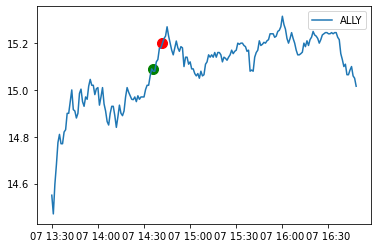

PENN analysis for run 541 with profit -66.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6462.82,-6462.82,buy,2020-05-07 16:20:19.390145,17.42,"[15.16, 16.2601, 16.28, 17.03, 17.1, 17.17, 17.21]",[17.7032],371,"{'avg': 16.7054, 'rsi': 66.21793382932324, 'macd': [0.02628308991325312, 0.02833239892672168, 0.0351433116987927, 0.041730285389743216, 0.046814321353995325], 'vwap': 17.4233, 'supports': [16.2601, 17.03, 17.1, 17.17, 17.21], 'sell_macd': [0.01717288383229132, 0.01837853467988282, 0.022679320604243713, 0.026811370407585855, 0.029942690119181492], 'slow macd': [0.03180013411584781, 0.03217881949942125, 0.033584113297742135, 0.03515438302055074, 0.03662282488384605], 'macd_signal': [0.013478717031080903, 0.016449453410209057, 0.020188225067925787, 0.02449663713228927, 0.028960173976630484], 'resistances': [17.7032], 'sell_macd_signal': [0.00911653939235928, 0.010968938449863987, 0.013311014880739932, 0.016011085986109116, 0.018797406812723592]}",18.19,17.17
1,-66.78,6396.04,sell,2020-05-07 16:42:02.981169,17.24,None,None,371,"{'avg': 16.7325, 'rsi': [44.45147937635933, 40.10036561339122], 'vwap': 17.2765, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.009184845005740535, 'sell_macd': [0.009560047129596683, 0.008597666193697506, 0.006697139929443097, 0.0030513124517206336, -0.0019071415887381704], 'sell_macd_signal': [0.01422750804664347, 0.013101539676054277, 0.011820659726732042, 0.01006679027172976, 0.007672003899636173]}",18.19,17.17


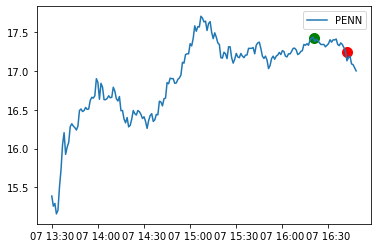

NCLH analysis for run 541 with profit 14.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4440.00,-4440.00,buy,2020-05-07 16:27:25.025137,12.00,"[11.45, 11.57, 11.5739, 11.5748, 11.585, 11.615, 11.69, 11.71, 11.7801, 11.7957]","[12.52, 12.6114]",370,"{'avg': 11.6869, 'rsi': 67.88988429514792, 'macd': [0.03967625109172701, 0.04327877287362902, 0.04839210164436736, 0.050107762628343266, 0.051024502571589636], 'vwap': 12.015, 'supports': [11.615, 11.655, 11.69, 11.71, 11.7801, 11.7957], 'sell_macd': [0.023996578827516046, 0.026265314555777408, 0.029505039609540873, 0.03051385082533642, 0.030997160203549257], 'slow macd': [0.02875880650565321, 0.030193996179418647, 0.032024302238841784, 0.03330836342787613, 0.034465257207267896], 'macd_signal': [0.03148676588484945, 0.033845167282605365, 0.036754554154957764, 0.039425195849634866, 0.04174505719402582], 'resistances': [12.52, 12.6114], 'sell_macd_signal': [0.01879969379892546, 0.02029281795029585, 0.022135262282144855, 0.023810979990783167, 0.025248216033336386]}",12.78,11.76
1,-2609.92,1830.08,sell,2020-05-07 16:34:05.862499,12.04,None,None,152,"{'avg': 11.6959, 'rsi': [63.15581725545325, 61.601111237232566], 'vwap': 12.0416, 'reasons': 'bail', 'movement': 0.0034250000000000114, 'sell_macd': [0.035793106745016345, 0.033654652091893666, 0.03314086077657841, 0.032284129092220226, 0.03075571311619818], 'sell_macd_signal': [0.029311288250187622, 0.03017996101852883, 0.030772140970138744, 0.03107453859455504, 0.03101077349888367]}",12.78,11.76
2,14.80,2624.72,sell,2020-05-07 16:34:05.941591,12.04,None,None,218,"{'avg': 11.6959, 'rsi': [63.15581725545325, 61.601111237232566], 'vwap': 12.0416, 'reasons': 'bail', 'movement': 0.0034250000000000114, 'sell_macd': [0.035793106745016345, 0.033654652091893666, 0.03314086077657841, 0.032284129092220226, 0.03075571311619818], 'sell_macd_signal': [0.029311288250187622, 0.03017996101852883, 0.030772140970138744, 0.03107453859455504, 0.03101077349888367]}",12.78,11.76


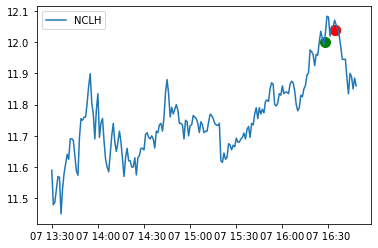

GNMK analysis for run 541 with profit 49.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5547.0,-5547.0,buy,2020-05-07 16:15:51.908160,12.90,"[11.17, 12.11, 12.12, 12.14, 12.2901, 12.57, 12.71]",[13.07],430,"{'avg': 12.0613, 'rsi': 69.656696766366, 'macd': [0.02890585804232515, 0.034380648908410194, 0.0406713750979808, 0.04556728450464753, 0.05004052082605881], 'vwap': 12.9085, 'supports': [12.11, 12.12, 12.2901, 12.57, 12.71], 'sell_macd': [0.01541914758187346, 0.01906799426992123, 0.02322205669866051, 0.026437922789904533, 0.029353689578018205], 'slow macd': [0.06312491582345992, 0.06366011723694598, 0.0645305122723272, 0.06531446146357922, 0.06616316567917835], 'macd_signal': [0.030650289125110496, 0.031396361081770435, 0.03325136388501251, 0.035714548008939515, 0.03857974257236337], 'resistances': [13.07], 'sell_macd_signal': [0.016162562863962705, 0.01674364914515441, 0.01803933065585563, 0.01971904908266541, 0.02164597718173597]}",13.57,12.69
1,-68.8,5478.2,sell,2020-05-07 16:28:24.404195,12.74,None,None,430,"{'avg': 12.0796, 'rsi': [42.828219522895836, 42.74581904725187], 'vwap': 12.741, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.012403100775193809, 'sell_macd': [0.008594987272040555, 0.007403407363456793, 0.005339794352048344, 0.0016156829879374612, -0.0013383736982248706], 'sell_macd_signal': [0.014755954984911505, 0.013285445460620562, 0.01169631523890612, 0.009680188788712388, 0.007476476291324936]}",13.57,12.69
2,-6157.6,-6088.8,buy,2020-05-07 16:42:07.652936,12.90,"[11.17, 12.11, 12.12, 12.14, 12.2901, 12.57, 12.71, 12.737, 12.78]",[13.07],472,"{'avg': 12.0964, 'rsi': 64.92642299204611, 'macd': [0.009819016579893258, 0.009940448722129958, 0.012315468791150863, 0.018423356665270063, 0.02299878612031847], 'vwap': 12.899, 'supports': [12.11, 12.2901, 12.57, 12.71, 12.737, 12.78], 'sell_macd': [0.005053016379298114, 0.005186505619265702, 0.00678160755145818, 0.010793614153797648, 0.013779676257518858], 'slow macd': [0.04064211576805299, 0.039926584364687656, 0.039684223670324315, 0.04027742284968738, 0.04075876696016856], 'macd_signal': [0.007813736064066885, 0.0082390785956795, 0.009054356634773771, 0.01092815664087303, 0.013342282536762118], 'resistances': [13.07], 'sell_macd_signal': [0.003368702728238866, 0.0037322633064442333, 0.004342132155447023, 0.005632428555117148, 0.007261878095597489]}",13.50,12.70
3,49.2,6206.8,sell,2020-05-07 16:47:21.637344,13.15,None,None,472,"{'avg': 12.124, 'rsi': [74.86653976896656, 79.49161715186364], 'vwap': 13.1102, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.017054263565891386, 'sell_macd': [0.021796976282372427, 0.027061061109675322, 0.030037477064592366, 0.03482380797667517, 0.042257003388989745], 'sell_macd_signal': [0.010418248382302982, 0.01374681092777745, 0.017004944155140433, 0.02056871691944738, 0.024906374213355852]}",13.50,12.70


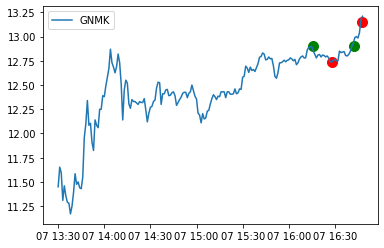

SU analysis for run 541 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9224.04,-9224.04,buy,2020-05-07 16:17:14.313542,16.59,"[16.16, 16.24, 16.25, 16.29, 16.385, 16.43, 16.45, 16.46]",[16.78],556,"{'avg': 16.4195, 'rsi': 63.98960270286674, 'macd': [0.011048637780536552, 0.013361264990390254, 0.01422316647969879, 0.017129520450186675, 0.01921137019401442], 'vwap': 16.59, 'supports': [16.16, 16.24, 16.43, 16.45, 16.46], 'sell_macd': [0.006725295358688044, 0.008224296759678396, 0.008766060231099715, 0.010632810205830623, 0.011949332131521828], 'slow macd': [0.018099921907669625, 0.018467626671704096, 0.018616454402756943, 0.019203414335400737, 0.019712723070973937], 'macd_signal': [0.0041116738908476055, 0.005961592110756135, 0.007613906984544666, 0.009517029677673068, 0.011455897780941339], 'resistances': [16.78], 'sell_macd_signal': [0.0020067965010278207, 0.0032502965527579355, 0.004353449288426291, 0.005609321471907158, 0.006877323603830092]}",17.1,16.42
1,-3898.65,5325.39,sell,2020-05-07 16:31:58.750952,16.59,None,None,321,"{'avg': 16.4328, 'rsi': [58.49215484137679, 58.492154841376795], 'vwap': 16.5963, 'reasons': 'bail', 'movement': 0.00030138637733568446, 'sell_macd': [0.010166789962045897, 0.009728658642732313, 0.009260911398556004, 0.009295641969348623, 0.009201982128804076], 'sell_macd_signal': [0.010122174172891544, 0.010043471066859698, 0.00988695913319896, 0.009768695700428893, 0.00965535298610393]}",17.1,16.42
2,0.00,3898.65,sell,2020-05-07 16:31:58.818529,16.59,None,None,235,"{'avg': 16.4328, 'rsi': [58.49215484137679, 58.492154841376795], 'vwap': 16.5963, 'reasons': 'bail', 'movement': 0.00030138637733568446, 'sell_macd': [0.010166789962045897, 0.009728658642732313, 0.009260911398556004, 0.009295641969348623, 0.009201982128804076], 'sell_macd_signal': [0.010122174172891544, 0.010043471066859698, 0.00988695913319896, 0.009768695700428893, 0.00965535298610393]}",17.1,16.42


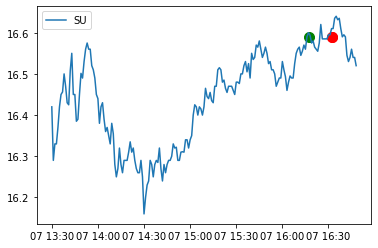

AAL analysis for run 541 with profit 25.22


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12282.14,-12282.14,buy,2020-05-07 16:28:50.475694,9.74,"[9.3699, 9.3899, 9.5799, 9.6019, 9.6188, 9.62, 9.6302, 9.66, 9.6919]","[9.82, 9.8254, 9.83]",1261,"{'avg': 9.5627, 'rsi': 65.14371636444677, 'macd': [0.012853657524958706, 0.012943360833569173, 0.012866138516001158, 0.01385559523567359, 0.015270632890851843], 'vwap': 9.7451, 'supports': [9.5799, 9.6019, 9.6188, 9.62, 9.6302, 9.66, 9.6919], 'sell_macd': [0.007505668356412087, 0.007549000985184406, 0.007484727696109417, 0.008116661137140824, 0.009023146141357685], 'slow macd': [0.013400372198161037, 0.013546062259919722, 0.013658436743352098, 0.013979884140155718, 0.014413203181932843], 'macd_signal': [0.013385444091307543, 0.013297027439759869, 0.013210849655008126, 0.013339798771141219, 0.013725965595083343], 'resistances': [9.82, 9.8254, 9.83], 'sell_macd_signal': [0.00794779269733303, 0.007868034354903306, 0.007791373023144528, 0.007856430645943787, 0.008089773745026566]}",9.97,9.67
1,25.22,12307.36,sell,2020-05-07 16:38:07.739285,9.76,None,None,1261,"{'avg': 9.5725, 'rsi': [62.44721138001832, 58.81912318226652], 'vwap': 9.7703, 'reasons': 'bail', 'movement': 0.003080082135523548, 'sell_macd': [0.015038963730598098, 0.01579650282067746, 0.015662163113978167, 0.015068363821562514, 0.013916463544074276], 'sell_macd_signal': [0.012875296995784493, 0.013459538160763087, 0.013900063151406104, 0.014133723285437386, 0.014090271337164765]}",9.97,9.67


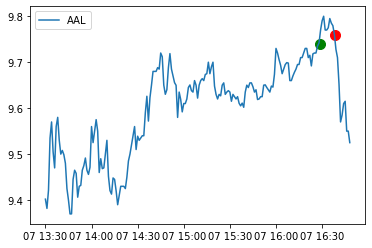

FEYE analysis for run 541 with profit 14.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-16252.35,-16252.35,buy,2020-05-07 16:26:16.133508,11.17,"[10.608, 10.655, 10.69, 10.745, 10.97, 11.09, 11.105, 11.1168, 11.12, 11.13]","[11.535, 11.538]",1455,"{'avg': 10.9145, 'rsi': 66.0342915126374, 'macd': [0.0009693827742243144, 0.0013125339822845916, 0.0021008999261233896, 0.003492344469858466, 0.0061381503719886155], 'vwap': 11.1604, 'supports': [10.745, 10.97, 11.09, 11.105, 11.1168, 11.12, 11.13], 'sell_macd': [0.0004250536485432832, 0.0006559100221572578, 0.0011753317415674758, 0.002084292409401556, 0.0038044657556426387], 'slow macd': [0.015807407333660706, 0.015456693351795892, 0.015216461586231134, 0.015131040099262805, 0.015348121665871517], 'macd_signal': [0.002040715549854404, 0.0018950792363404416, 0.0019362433742970311, 0.002247463593409318, 0.0030256009491251776], 'resistances': [11.538], 'sell_macd_signal': [0.0011005183783436658, 0.0010115967071063843, 0.0010443437139986025, 0.001252333453079193, 0.0017627599135918823]}",11.36,11.11
1,14.55,16266.90,sell,2020-05-07 16:38:20.544585,11.18,None,None,1455,"{'avg': 10.9236, 'rsi': [55.06031646549185, 56.77705980260056], 'vwap': 11.1811, 'reasons': 'bail', 'movement': 0.0013428827215757, 'sell_macd': [0.013426171759759242, 0.01342282847301668, 0.012466680087591442, 0.011040243941966565, 0.010045095725351061], 'sell_macd_signal': [0.009433345794808434, 0.010231242330450082, 0.010678329881878354, 0.010750712693895995, 0.010609589300187008]}",11.36,11.11


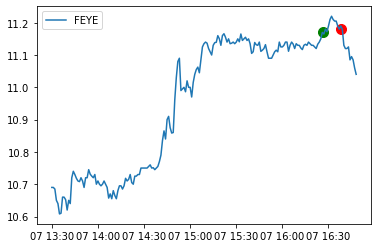

OLN analysis for run 541 with profit -63.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10458.0,-10458.0,buy,2020-05-07 16:27:34.011093,11.62,"[11.17, 11.31, 11.4, 11.41, 11.53]",[11.715],900,"{'avg': 11.3535, 'rsi': 64.51784598033335, 'macd': [0.01327210696194392, 0.012912004966709745, 0.01288158881697754, 0.013899563755883193, 0.015344420887435817], 'vwap': 11.62, 'supports': [11.31, 11.4, 11.41, 11.53], 'sell_macd': [0.007017878636476738, 0.006829527456991613, 0.006853805402109003, 0.007557738795679114, 0.00853278119591927], 'slow macd': [0.026466117240168785, 0.02621793906314629, 0.02602764328482543, 0.02604924218164406, 0.026188987120809415], 'macd_signal': [0.013059414931759517, 0.013029932938749562, 0.013000264114395157, 0.013180124042692764, 0.013612983411641374], 'resistances': [11.715], 'sell_macd_signal': [0.006647880969447821, 0.0066842102669565796, 0.0067181292939870645, 0.006886051194325475, 0.007215397194644234]}",11.93,11.52
1,-63.0,10395.0,sell,2020-05-07 16:36:21.471455,11.55,None,None,900,"{'avg': 11.3618, 'rsi': [41.479521450205084, 39.893795878562], 'vwap': 11.555, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.005593803786574828, 'sell_macd': [0.006145409460799556, 0.004718345665439827, 0.0027918239331405914, 0.0009686664283208302, -0.0007242961264530834], 'sell_macd_signal': [0.007606217581424046, 0.007028643198227202, 0.00618127934520988, 0.00513875676183207, 0.003966146184175039]}",11.93,11.52


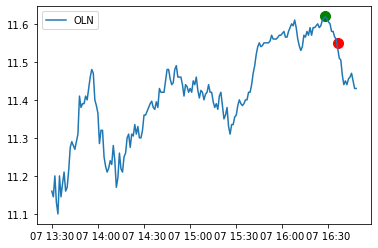

WMB analysis for run 541 with profit -40.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9974.72,-9974.72,buy,2020-05-07 16:14:58.172764,19.52,"[19.21, 19.285, 19.29, 19.3, 19.355, 19.36, 19.365]",[19.69],511,"{'avg': 19.3074, 'rsi': 69.84264898036197, 'macd': [0.021941588942347323, 0.02678250939380078, 0.03200907089401639, 0.03374487752929767, 0.035518003781675134], 'vwap': 19.525, 'supports': [19.285, 19.29, 19.3, 19.355, 19.36, 19.365], 'sell_macd': [0.013305145175646516, 0.016409423992772787, 0.019747700681538305, 0.02079379030029571, 0.021858356362962184], 'slow macd': [0.016517498955582965, 0.017853131313831483, 0.019402062753687943, 0.02039625827231717, 0.021438265011731517], 'macd_signal': [0.017832509338613484, 0.019622509349650943, 0.022099821658524033, 0.02442883283267876, 0.026646667022478036], 'resistances': [19.69], 'sell_macd_signal': [0.01076789416523097, 0.011896200130739333, 0.013466500240899128, 0.014931958252778444, 0.01631723787481519]}",20.08,19.34
1,-40.88,9933.84,sell,2020-05-07 16:30:15.698504,19.44,None,None,511,"{'avg': 19.3174, 'rsi': [46.0209827833353, 45.19266783125172], 'vwap': 19.4409, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.003980532786885252, 'sell_macd': [0.0038820902160772164, 0.0028929464219622503, 0.002344354550938732, 0.0011072134235057263, -1.1431785189586208e-05], 'sell_macd_signal': [0.009028187983999066, 0.007801139671591703, 0.006709782647461108, 0.005589268802670032, 0.004469128685098108]}",20.08,19.34


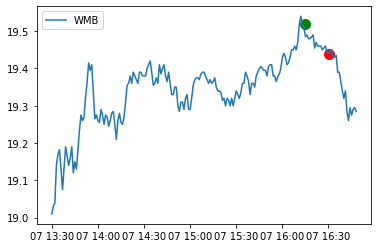

CCL analysis for run 541 with profit 15.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10708.92,-10708.92,buy,2020-05-07 16:19:55.927235,13.59,"[13.23, 13.28, 13.293, 13.335, 13.3601, 13.406, 13.445, 13.495]",[13.9987],788,"{'avg': 13.3541, 'rsi': 63.78492821707481, 'macd': [0.010315445844687687, 0.011745408647099609, 0.012731899063266994, 0.014556278744729312, 0.016617473324281207], 'vwap': 13.5816, 'supports': [13.335, 13.3601, 13.406, 13.445, 13.495], 'sell_macd': [0.005254696283952143, 0.006228085007343509, 0.00690568550599302, 0.008123222446423384, 0.009485936653947036], 'slow macd': [0.02016323409773335, 0.02033709224910396, 0.020464520972536704, 0.020788933371068907, 0.021214090186559176], 'macd_signal': [0.012352872366101424, 0.012231379622301062, 0.012331483510494248, 0.01277644255734126, 0.01354464871072925], 'resistances': [13.985, 13.9987], 'sell_macd_signal': [0.006475275181221056, 0.006425837146445547, 0.0065218068183550415, 0.00684208994396871, 0.007370859285964375]}",13.95,13.47
1,15.76,10724.68,sell,2020-05-07 16:36:08.694903,13.61,None,None,788,"{'avg': 13.3679, 'rsi': [57.94099820503617, 57.9636968506348], 'vwap': 13.6239, 'reasons': 'bail', 'movement': 0.0022222222222222717, 'sell_macd': [0.017028750237418677, 0.01744065549753593, 0.01701563809636042, 0.01568944741886824, 0.014457487833563931], 'sell_macd_signal': [0.012450111842412414, 0.013448220573437118, 0.014161704078021777, 0.01446725274619107, 0.014465299763665642]}",13.95,13.47


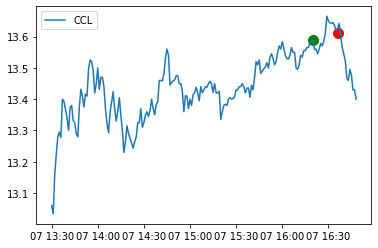

APA analysis for run 541 with profit -68.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7054.46,-7054.46,buy,2020-05-07 16:32:14.542767,12.29,"[11.94, 11.95, 11.965, 12.06, 12.12, 12.22, 12.29]","[12.32, 12.33, 12.365]",574,"{'avg': 12.0609, 'rsi': 66.47170574952428, 'macd': [0.0025127959881316997, 0.0071037669102604895, 0.00942314564514568, 0.014722680031221458, 0.018706957056993545], 'vwap': 12.295, 'supports': [11.94, 11.965, 12.12, 12.22, 12.29], 'sell_macd': [0.0030422487421937205, 0.0059503799955678005, 0.007359957855396004, 0.010700408683115725, 0.013164391033505751], 'slow macd': [-0.00019666452356759123, 0.0007028429587450091, 0.0012893904777246945, 0.002546682872470285, 0.0036993590295342216], 'macd_signal': [-0.010425477608181502, -0.006919628704493104, -0.0036510738345653473, 2.367693859201426e-05, 0.0037603329622723208], 'resistances': [12.32, 12.33, 12.365], 'sell_macd_signal': [-0.005397642994388368, -0.003128038396397134, -0.0010304391460385061, 0.00131573041979234, 0.003685462542535022]}",12.79,12.13
1,-68.88,6985.58,sell,2020-05-07 16:42:07.788713,12.17,None,None,574,"{'avg': 12.0658, 'rsi': [40.043000341846614, 39.358998910202615], 'vwap': 12.17, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.009764035801464543, 'sell_macd': [0.013547808560561592, 0.008023724240555197, 0.005168285494569602, 0.0010579658808858028, -0.002418360647711282], 'sell_macd_signal': [0.012440352892076182, 0.011557027161771986, 0.010279278828331509, 0.008435016238842368, 0.006264340861531638]}",12.79,12.13


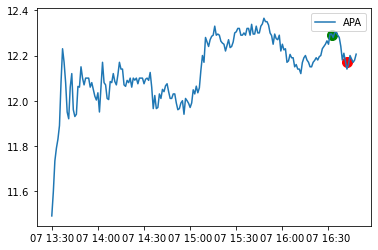

In [26]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))